In [109]:
from google.colab import auth
import pandas as pd
import gspread
from google.auth import default
import matplotlib.pyplot as plt

col_order = ['Yellow light time','Red light time','Brake Time']
cond_order= ['Baseline','Train','Test']

# Importing data

In [110]:
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [111]:
worksheet = gc.open('Implicit_Timing_Anonymized_Young_Group').sheet1
rows = worksheet.get_all_values()
df = pd.DataFrame.from_records(rows[1:],columns=rows[0])

In [112]:
df.columns

Index(['ParticipantID', 'Gender', 'Age', 'Education', 'Block', 'Brake Time',
       'Yellow light time', 'Red light time'],
      dtype='object')

In [113]:
df.head()

,ParticipantID,Gender,Age,Education,Block,Brake Time,Yellow light time,Red light time
0,8bdbccee,Male,34,16,Baseline,8511,6500,8000
1,8bdbccee,Male,34,16,Baseline,0,500,2000
2,8bdbccee,Male,34,16,Baseline,5492,3500,5000
3,8bdbccee,Male,34,16,Baseline,2581,500,2000
4,8bdbccee,Male,34,16,Baseline,8544,6500,8000


In [114]:
df.isna().any()

ParticipantID        False
Gender               False
Age                  False
Education            False
Block                False
Brake Time           False
Yellow light time    False
Red light time       False
dtype: bool

# Analyzing Participants

In [115]:
participant_df = df[['ParticipantID','Gender','Age','Education']]

In [116]:
participant_df = participant_df.drop_duplicates(keep='first')
participant_df.Gender.value_counts()

Female    15
Male      13
Name: Gender, dtype: int64

In [117]:
participant_df.drop_duplicates(keep='first').groupby('Gender').agg(['mean','std','size']).round(2)

<ipython-input-117-899ba64fcf58>:1: FutureWarning: ['ParticipantID'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  participant_df.drop_duplicates(keep='first').groupby('Gender').agg(['mean','std','size']).round(2)


Age                Education           
                mean   std size          mean   std size
Gender                                                  
Female  1.953575e+28  3.31   15  1.346775e+28  2.74   15
Male    2.637140e+24  3.77   13  1.245532e+24  3.25   13

In [118]:
df['ParticipantID'].nunique()

28

In [119]:
df.groupby('ParticipantID').size()

ParticipantID
00ad5085    24
17e454fb    25
1991b6f9    24
21279c4f    24
434eecd2    24
44e1fa29    24
509f71f3    24
57008c01    24
7bfcc746    24
7f1e43d8    24
8242b654    24
8bdbccee    24
90801745    24
929d1df3    24
96e65548    24
9916d1fc    24
a1204185    24
b28f9f27    24
c482b3a9    24
ce1e6162    24
d14eb181    24
d31e4f68    24
d94de864    24
d974eb25    24
da9bfc40    24
dc9a3f41    24
e6bec5bc    24
fa9bbab0    24
dtype: int64

In [120]:
df.describe()

,ParticipantID,Gender,Age,Education,Block,Brake Time,Yellow light time,Red light time
count,673,673,673,673,673,673,673,673
unique,28,2,14,10,3,565,3,3
top,17e454fb,Female,28,16,Train,0,6500,8000
freq,25,361,120,120,336,5,225,225


# Data Type Conversion

In [121]:
df.dtypes

ParticipantID        object
Gender               object
Age                  object
Education            object
Block                object
Brake Time           object
Yellow light time    object
Red light time       object
dtype: object

In [122]:
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')
df['Education'] = pd.to_numeric(df['Education'], errors='coerce')
df['Brake Time'] = pd.to_numeric(df['Brake Time'], errors='coerce')
df['Yellow light time'] = pd.to_numeric(df['Yellow light time'], errors='coerce')
df['Red light time'] = pd.to_numeric(df['Red light time'], errors='coerce')

In [123]:
df.dtypes

ParticipantID        object
Gender               object
Age                   int64
Education             int64
Block                object
Brake Time            int64
Yellow light time     int64
Red light time        int64
dtype: object

# Outlier Removal

In [124]:
df[df['Brake Time']==0]

,ParticipantID,Gender,Age,Education,Block,Brake Time,Yellow light time,Red light time
1,8bdbccee,Male,34,16,Baseline,0,500,2000
27,d31e4f68,Female,29,20,Baseline,0,500,2000
145,c482b3a9,Male,23,16,Baseline,0,500,2000
187,44e1fa29,Female,36,16,Test,0,500,2000
554,929d1df3,Female,25,18,Baseline,0,500,2000


**5 participants did not press brake pedal during 5 trials in which the Red light appreas only 2 seconds after the start of the experiment. 4 out of the 5 trials were in the Baseline condition and the remainig 1 was in the Test condition. These trials were removed from the rest of the analysis. **

In [125]:
df = df[~(df['Brake Time']==0)]

# Calculating Reaction Time

In [126]:
df['reactionTime'] = df['Brake Time']-df['Red light time']

<Axes: >

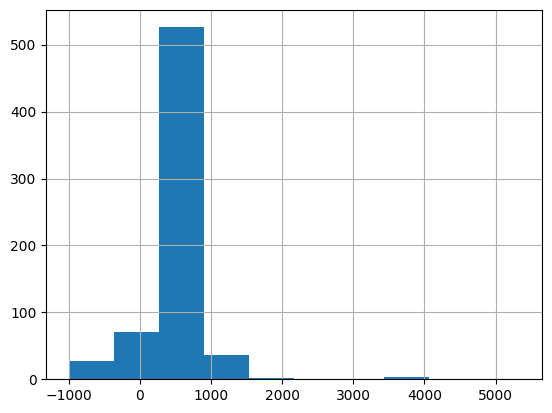

In [127]:
df['reactionTime'].hist()

# Exploring Negative Reaction time (Break sooner than the signal)

**Number of unique participants who had negative reaction time:**

In [128]:
df[df['reactionTime']<0]['ParticipantID'].nunique()

21

**Distribution of trails with negative reaction time across participants:**

In [129]:
df[df['reactionTime']<0]['ParticipantID'].value_counts()

d14eb181    7
96e65548    7
dc9a3f41    6
9916d1fc    5
7bfcc746    5
90801745    4
44e1fa29    4
21279c4f    3
fa9bbab0    3
1991b6f9    2
929d1df3    2
00ad5085    1
a1204185    1
57008c01    1
8bdbccee    1
8242b654    1
d94de864    1
e6bec5bc    1
c482b3a9    1
d974eb25    1
7f1e43d8    1
Name: ParticipantID, dtype: int64

In [130]:
df[df['reactionTime']<0].groupby(['Gender','ParticipantID']).size()

Gender  ParticipantID
Female  00ad5085         1
        21279c4f         3
        44e1fa29         4
        57008c01         1
        7bfcc746         5
        929d1df3         2
        96e65548         7
        9916d1fc         5
        d14eb181         7
        d94de864         1
        dc9a3f41         6
        fa9bbab0         3
Male    1991b6f9         2
        7f1e43d8         1
        8242b654         1
        8bdbccee         1
        90801745         4
        a1204185         1
        c482b3a9         1
        d974eb25         1
        e6bec5bc         1
dtype: int64

**Conclusion:** 12 female participants ( vs 9 males) showed negative reaction time  meaning that they pressed the breake padeal soonder than seeing the Redlight

In [131]:
df[df['reactionTime']<0].groupby(['Gender','ParticipantID','Block']).size()

Gender  ParticipantID  Block
Female  00ad5085       Test     1
        21279c4f       Test     2
                       Train    1
        44e1fa29       Test     2
                       Train    2
        57008c01       Train    1
        7bfcc746       Test     4
                       Train    1
        929d1df3       Test     1
                       Train    1
        96e65548       Test     5
                       Train    2
        9916d1fc       Test     4
                       Train    1
        d14eb181       Test     6
                       Train    1
        d94de864       Train    1
        dc9a3f41       Test     6
        fa9bbab0       Test     2
                       Train    1
Male    1991b6f9       Test     2
        7f1e43d8       Train    1
        8242b654       Train    1
        8bdbccee       Train    1
        90801745       Test     4
        a1204185       Test     1
        c482b3a9       Test     1
        d974eb25       Test     1
        e6bec5bc   

In [132]:
df[df['reactionTime']<0].groupby(['Block']).size()

Block
Test     42
Train    16
dtype: int64

**Conclusion:** Out of 58 trials with negative reaction time, 16 trials (%27) belong to Trian condition and %72 belonged to Test condition (where Redlight signal is not being shown)




In [133]:
df[(df['Block']=='Baseline') & (df['reactionTime']<0)].shape[0]/df[(df['Block']=='Train')].shape[0]

0.0

In [134]:
df[(df['Block']=='Train') & (df['reactionTime']<0)].shape[0]/df[(df['Block']=='Train')].shape[0]

0.047619047619047616

In [135]:
df[(df['Block']=='Test') & (df['reactionTime']<0)].shape[0]/df[(df['Block']=='Test')].shape[0]

0.25149700598802394

**Conclusion:** in total, only  %04 for Train trials had negative reaction times. However, for Test condition, this amount surged to %25.

# Analyzing Reaction Time

In [136]:
df[df['reactionTime']>0].groupby(['Block']).size()

Block
Baseline    165
Test        125
Train       320
dtype: int64

In [137]:
df.groupby(['ParticipantID','Block','Red light time']).size()[:24]

ParticipantID  Block     Red light time
00ad5085       Baseline  2000              2
                         5000              2
                         8000              2
               Test      2000              2
                         5000              2
                         8000              2
               Train     2000              4
                         5000              4
                         8000              4
17e454fb       Baseline  2000              2
                         5000              2
                         8000              3
               Test      2000              2
                         5000              2
                         8000              2
               Train     2000              4
                         5000              4
                         8000              4
1991b6f9       Baseline  2000              2
                         5000              2
                         8000              2
               

In [138]:
df.drop(['Age','Education'],axis=1).groupby(['ParticipantID','Block','Red light time']).agg(['min','max','mean'])['reactionTime']

<ipython-input-138-cb7febb33479>:1: FutureWarning: ['Gender'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.drop(['Age','Education'],axis=1).groupby(['ParticipantID','Block','Red light time']).agg(['min','max','mean'])['reactionTime']


min   max    mean
ParticipantID Block    Red light time                   
00ad5085      Baseline 2000            673   764   718.5
                       5000            633   672   652.5
                       8000            682   769   725.5
              Test     2000            974  1418  1196.0
                       5000            -45   235    95.0
...                                    ...   ...     ...
fa9bbab0      Test     5000             -5    54    24.5
                       8000            -97   542   222.5
              Train    2000            478   594   514.5
                       5000           -889  1030   351.5
                       8000            487   618   521.5

[252 rows x 3 columns]

In [139]:
df.groupby(['ParticipantID','Block','Red light time']).mean()[:5]

<ipython-input-139-50f976d17d03>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby(['ParticipantID','Block','Red light time']).mean()[:5]


Age  Education  Brake Time  \
ParticipantID Block    Red light time                                
00ad5085      Baseline 2000            26.0       20.0      2718.5   
                       5000            26.0       20.0      5652.5   
                       8000            26.0       20.0      8725.5   
              Test     2000            26.0       20.0      3196.0   
                       5000            26.0       20.0      5095.0   

                                       Yellow light time  reactionTime  
ParticipantID Block    Red light time                                   
00ad5085      Baseline 2000                        500.0         718.5  
                       5000                       3500.0         652.5  
                       8000                       6500.0         725.5  
              Test     2000                        500.0        1196.0  
                       5000                       3500.0          95.0

<Axes: >

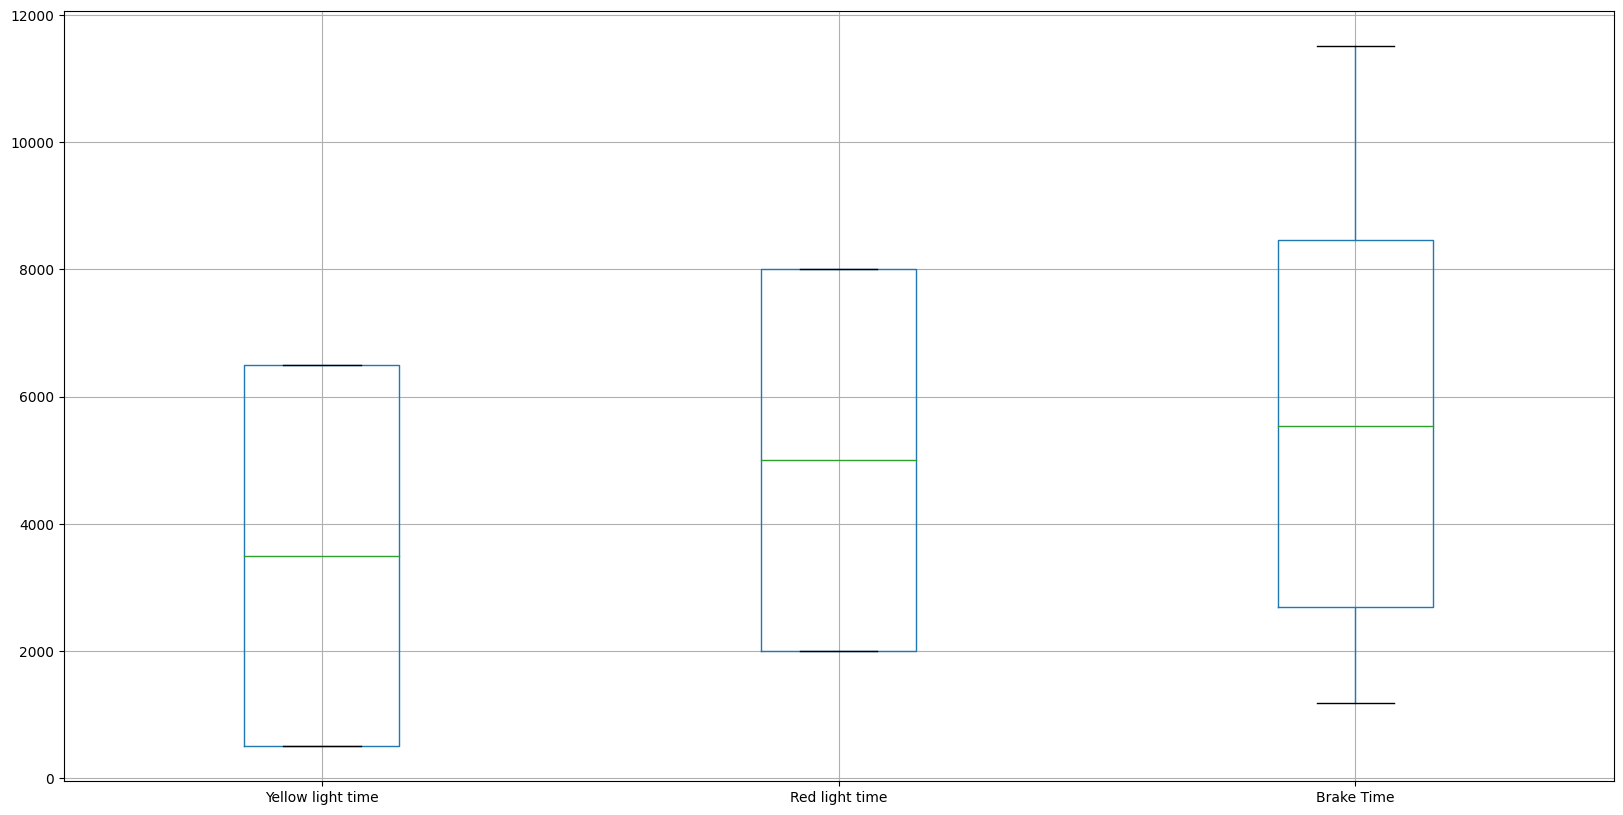

In [140]:
df.boxplot(column=col_order,figsize=(20,10))

In [141]:
df.groupby('Block')['reactionTime'].size()

Block
Baseline    165
Test        167
Train       336
Name: reactionTime, dtype: int64

array([[<Axes: title={'center': 'Baseline'}>,
        <Axes: title={'center': 'Test'}>],
       [<Axes: title={'center': 'Train'}>, <Axes: >]], dtype=object)

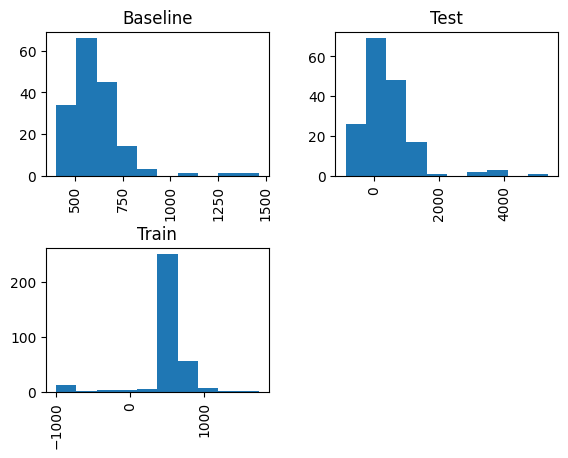

In [142]:
df.hist('reactionTime',by='Block')

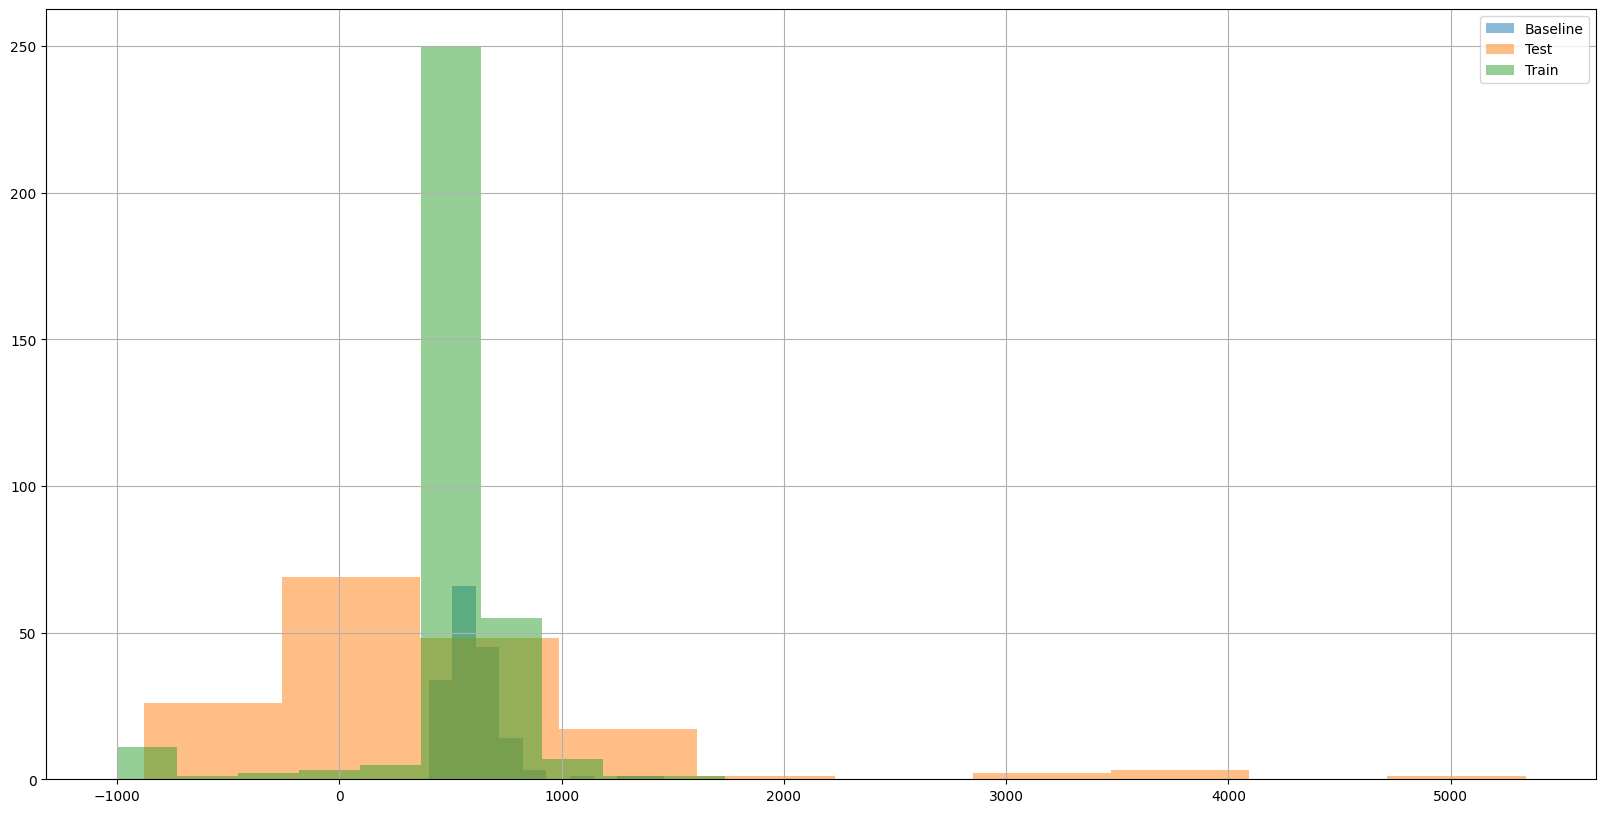

In [143]:
ax= df.groupby('Block')['reactionTime'].hist(figsize=(20,10),alpha=0.5,legend=True)

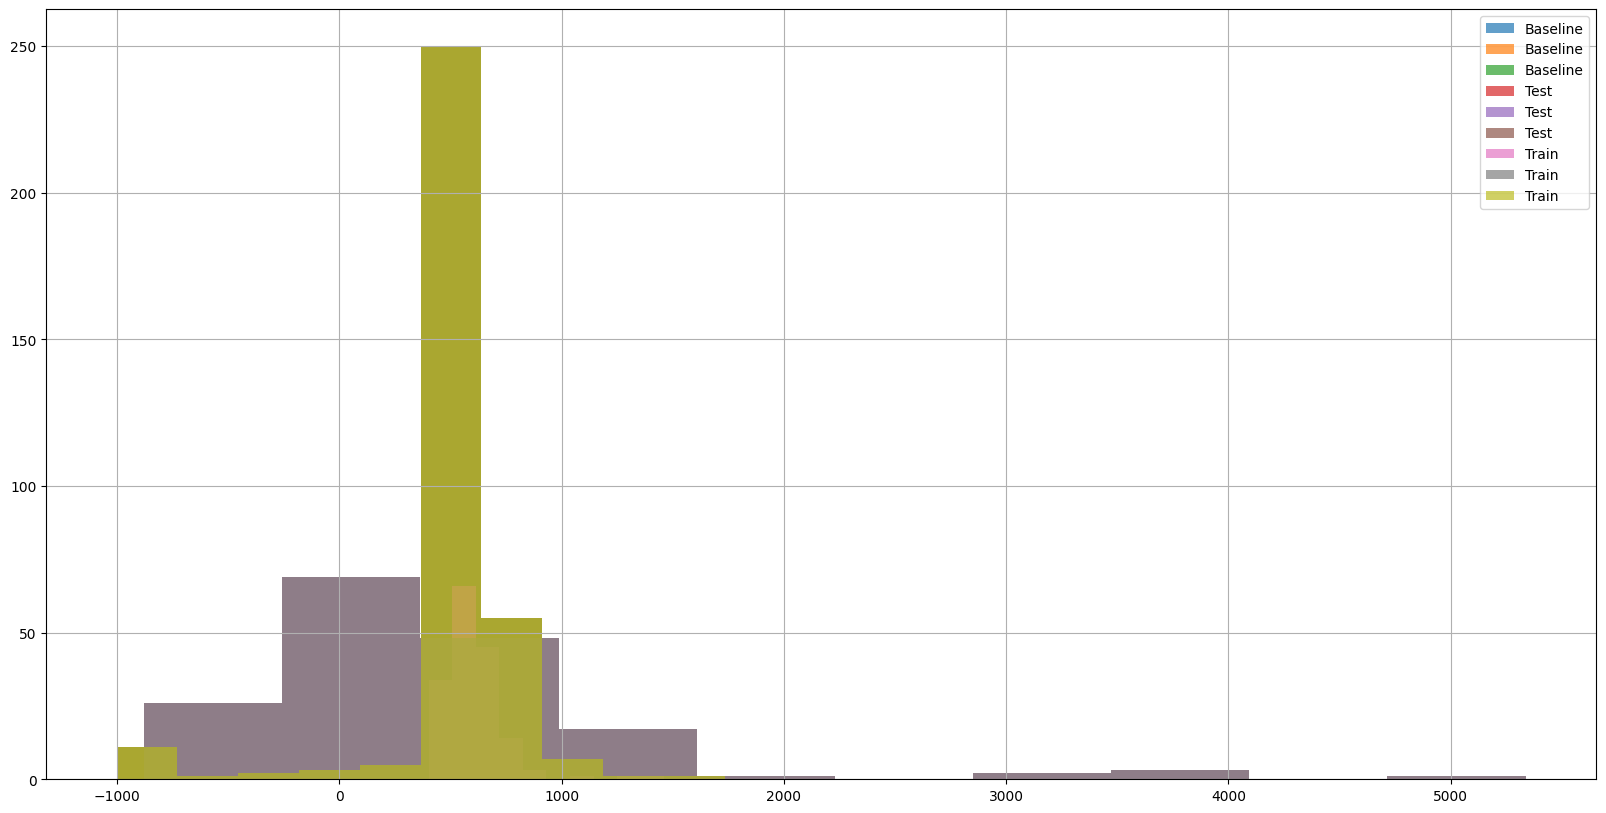

In [144]:
fig,ax = plt.subplots()
grouped = df.groupby('Block')
for (i, d) in grouped :
    grouped['reactionTime'].hist(figsize=(20,10),alpha=0.7, ax=ax, label=i)
ax.legend()

In [145]:
df.drop(['Age', 'Education'],axis=1).groupby('Block').agg(['mean','std','min','max']).round(2)

<ipython-input-145-ffe8c7017f1d>:1: FutureWarning: ['ParticipantID', 'Gender'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.drop(['Age', 'Education'],axis=1).groupby('Block').agg(['mean','std','min','max']).round(2)


Brake Time                       Yellow light time                \
               mean      std   min    max              mean      std  min   
Block                                                                       
Baseline    5696.52  2413.89  2489   9462           3590.91  2444.05  500   
Test        5441.43  2465.90  1189  11511           3517.96  2453.11  500   
Train       5509.45  2448.94  1178   9350           3500.00  2453.14  500   

               Red light time                      reactionTime                \
           max           mean      std   min   max         mean     std   min   
Block                                                                           
Baseline  6500        5090.91  2444.05  2000  8000       605.61  139.82   401   
Test      6500        5017.96  2453.11  2000  8000       423.46  840.27  -879   
Train     6500        5000.00  2453.14  2000  8000       509.45  317.65 -1003   

                
           max  
Block           
Baseline  1462  
Test      5338  
Train     1734

In [146]:
df.drop(['Age', 'Education'],axis=1).groupby('Block').mean().round(2)[col_order]

<ipython-input-146-1770ecd96bf5>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.drop(['Age', 'Education'],axis=1).groupby('Block').mean().round(2)[col_order]


,Yellow light time,Red light time,Brake Time
Block,,,
Baseline,3590.91,5090.91,5696.52
Test,3517.96,5017.96,5441.43
Train,3500.00,5000.00,5509.45


<ipython-input-148-2209351e691d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ax1 = df.drop(['Age', 'Education'],axis=1).groupby('Block').mean().round(2)[col_order].loc[['Baseline', 'Train', 'Test']].plot(kind='bar',figsize=(20,10), rot=45,fontsize=20)


Text(0.5, 0, 'Block')

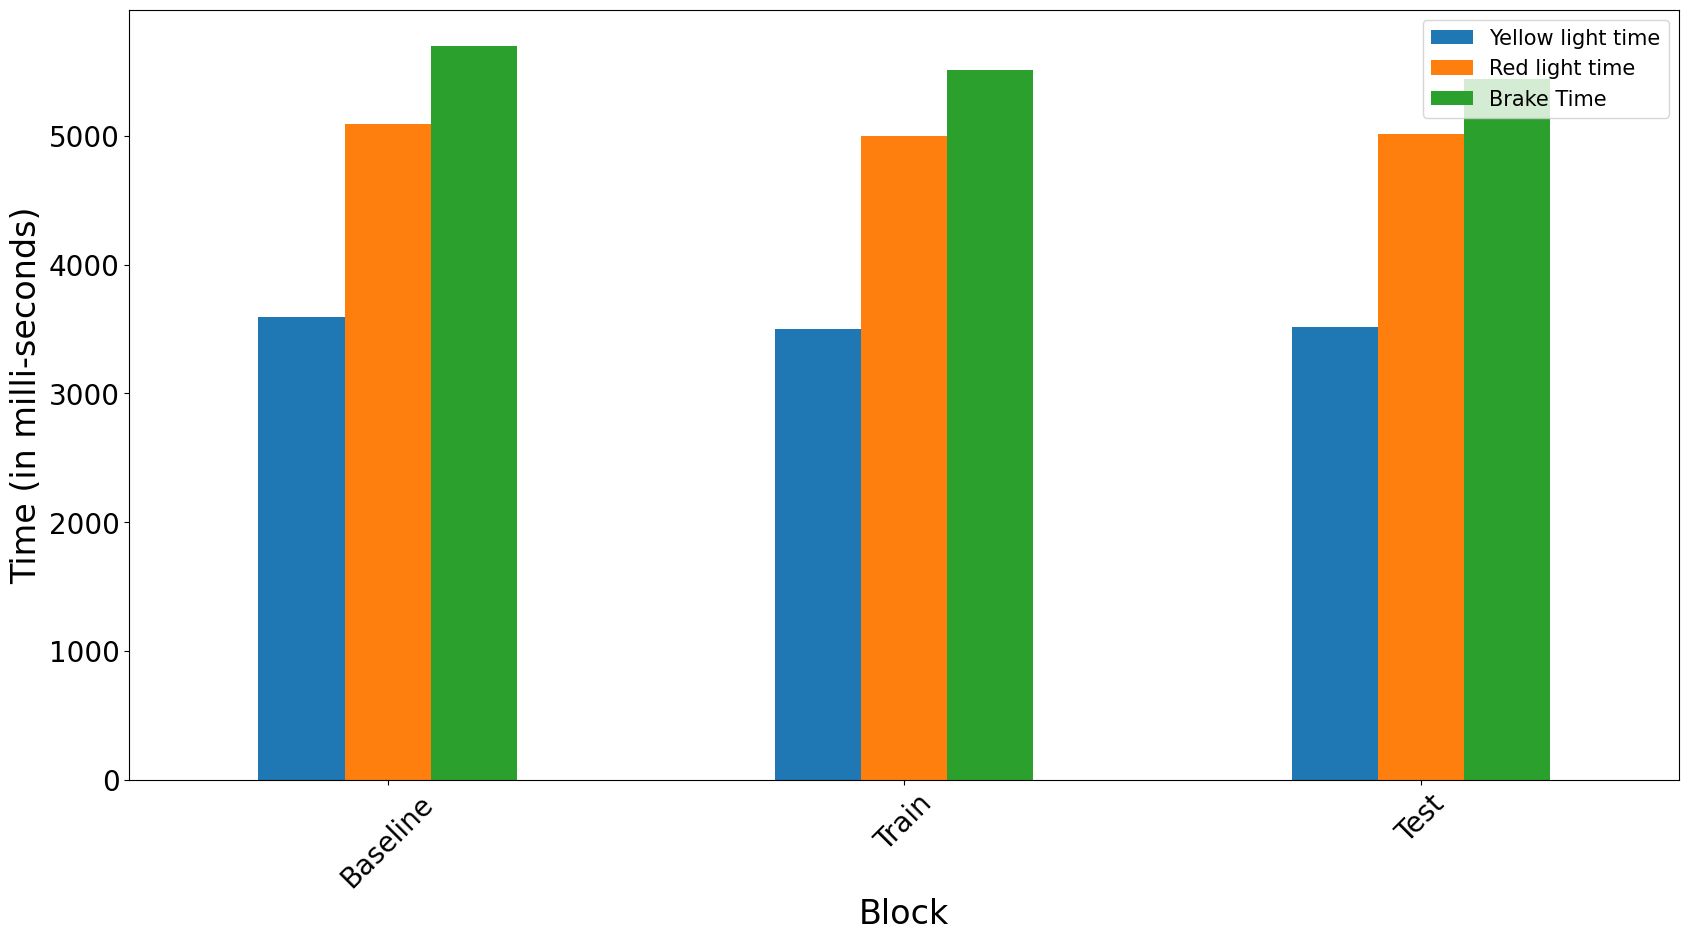

In [148]:
ax1 = df.drop(['Age', 'Education'],axis=1).groupby('Block').mean().round(2)[col_order].loc[['Baseline', 'Train', 'Test']].plot(kind='bar',figsize=(20,10), rot=45,fontsize=20)
ax1.legend(loc='upper right',fontsize=15)
ax1.set_ylabel('Time (in milli-seconds)',fontdict={'fontsize':24})
ax1.set_xlabel('Block',fontdict={'fontsize':24})

<ipython-input-149-a29093f4b0e7>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.drop(['Age', 'Education'],axis=1).groupby('Block').mean().round(2).loc[['Baseline', 'Train', 'Test']].plot(


<Axes: xlabel='Block'>

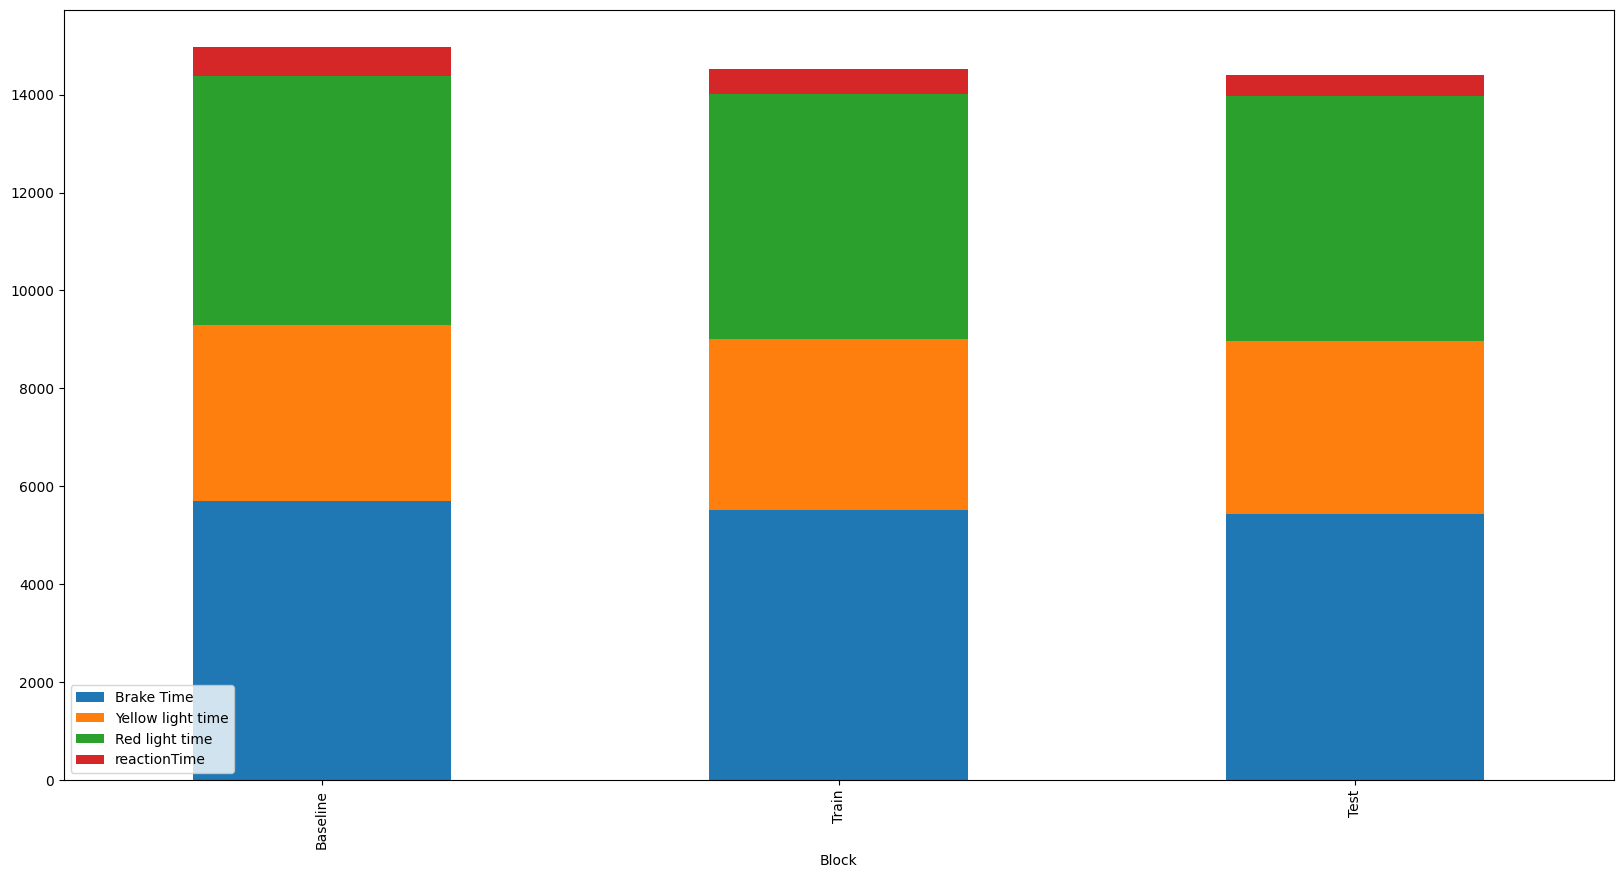

In [149]:
df.drop(['Age', 'Education'],axis=1).groupby('Block').mean().round(2).loc[['Baseline', 'Train', 'Test']].plot(
    kind='bar',stacked=True,figsize=(20,10))

# Overall Analysis

In [150]:
df.drop(['Gender','Age','Education'],axis=1).groupby(['Block','Red light time']).agg(['min','max','mean','median'])['reactionTime'].T.round(1)[cond_order]

<ipython-input-150-4f8473e00cec>:1: FutureWarning: ['ParticipantID'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  df.drop(['Gender','Age','Education'],axis=1).groupby(['Block','Red light time']).agg(['min','max','mean','median'])['reactionTime'].T.round(1)[cond_order]


Block          Baseline                  Train                    Test  \
Red light time     2000   5000    8000    2000    5000    8000    2000   
min               489.0  401.0   412.0  -822.0 -1003.0  -987.0  -811.0   
max              1334.0  926.0  1462.0  1734.0  1030.0  1350.0  5338.0   
mean              663.7  578.8   579.0   551.4   486.1   490.8   611.3   
median            641.0  567.0   542.0   549.0   549.5   520.0   432.0   

Block                           
Red light time    5000    8000  
min             -879.0  -714.0  
max             3528.0  3511.0  
mean             372.2   290.2  
median           232.5   274.0

In [151]:
df.drop(['Gender','Age','Education'],axis=1).groupby(['Block','Red light time']).mean()['reactionTime'].T.round(1)[cond_order]

<ipython-input-151-20d33ae8999d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.drop(['Gender','Age','Education'],axis=1).groupby(['Block','Red light time']).mean()['reactionTime'].T.round(1)[cond_order]


Block     Red light time
Baseline  2000              663.7
          5000              578.8
          8000              579.0
Train     2000              551.4
          5000              486.1
          8000              490.8
Test      2000              611.3
          5000              372.2
          8000              290.2
Name: reactionTime, dtype: float64

<ipython-input-152-27045c5c57c3>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.drop(['Gender','Age','Education'],axis=1).groupby(['Red light time','Block']).mean()['reactionTime'].round(1).unstack(level=1)[cond_order].plot(kind='bar',figsize=(20,10),rot=45,fontsize=20)


<Axes: xlabel='Red light time'>

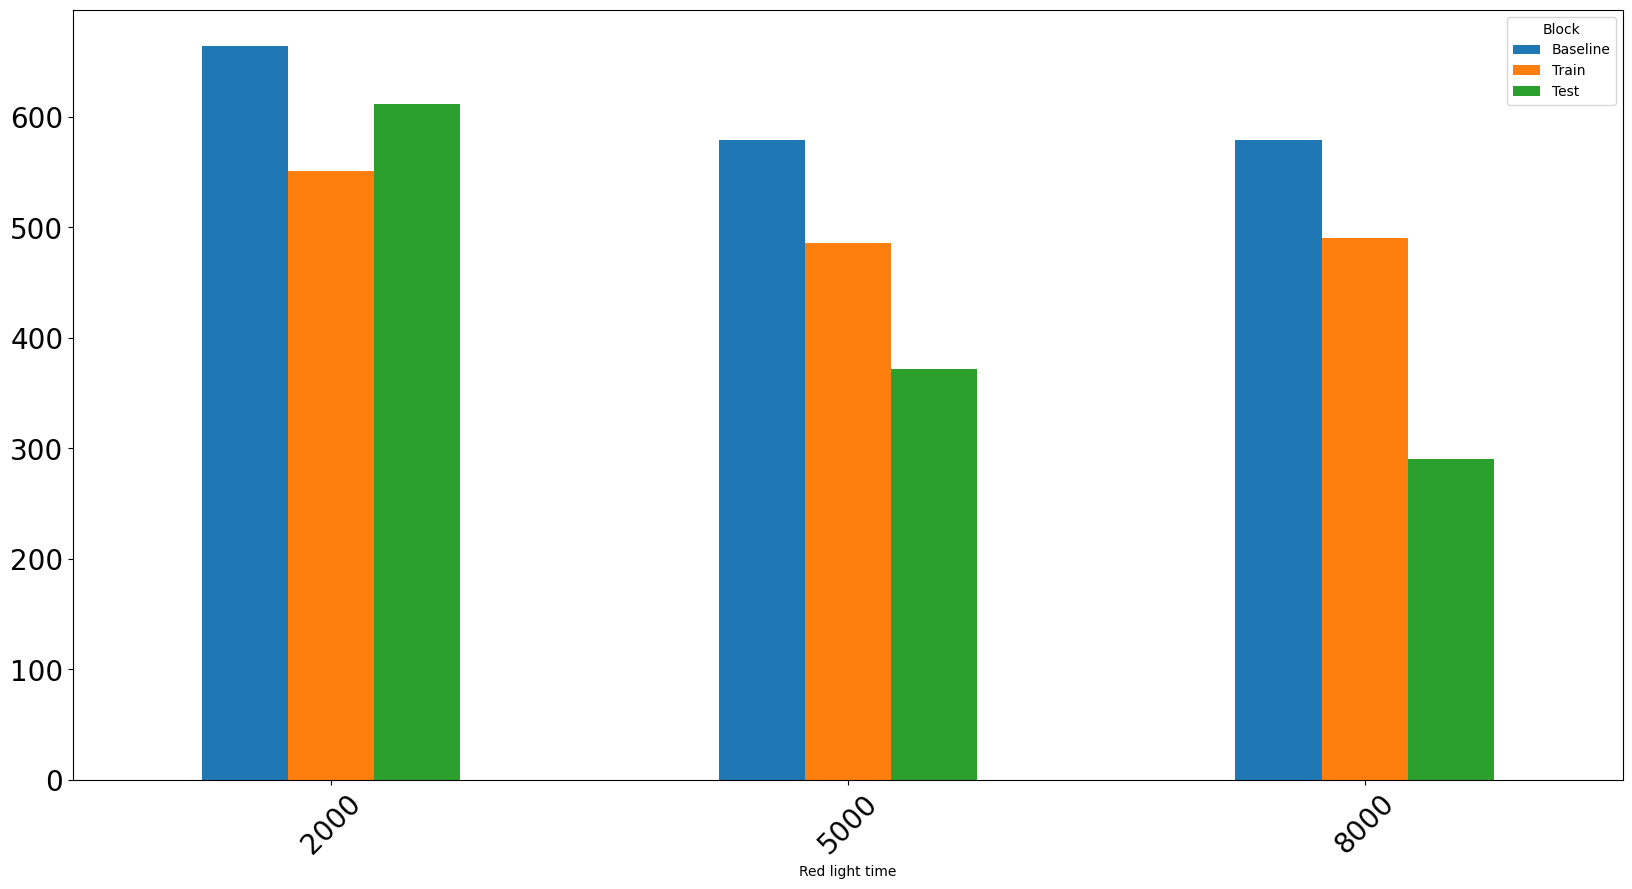

In [152]:
df.drop(['Gender','Age','Education'],axis=1).groupby(['Red light time','Block']).mean()['reactionTime'].round(1).unstack(level=1)[cond_order].plot(kind='bar',figsize=(20,10),rot=45,fontsize=20)

# Averaging the two trials of each time interval

In [153]:
df.groupby(['Red light time','Block']).size()

Red light time  Block   
2000            Baseline     52
                Test         55
                Train       112
5000            Baseline     56
                Test         56
                Train       112
8000            Baseline     57
                Test         56
                Train       112
dtype: int64

In [154]:
df_averaged = df.drop(['Gender','Age','Education','reactionTime'],axis=1).groupby(['ParticipantID','Block','Red light time']).mean().reset_index()

In [155]:
df_averaged.head()

,ParticipantID,Block,Red light time,Brake Time,Yellow light time
0,00ad5085,Baseline,2000,2718.5,500.0
1,00ad5085,Baseline,5000,5652.5,3500.0
2,00ad5085,Baseline,8000,8725.5,6500.0
3,00ad5085,Test,2000,3196.0,500.0
4,00ad5085,Test,5000,5095.0,3500.0


In [156]:
df_averaged.shape

(252, 5)

In [157]:
df_averaged['reactionTime'] = df_averaged['Brake Time']-df_averaged['Red light time']

In [158]:
df_averaged.groupby(['Red light time','Block']).size()

Red light time  Block   
2000            Baseline    28
                Test        28
                Train       28
5000            Baseline    28
                Test        28
                Train       28
8000            Baseline    28
                Test        28
                Train       28
dtype: int64

## Analyzing Negative Error

In [159]:
df_averaged[df_averaged['reactionTime']<0].shape

(19, 6)

In [160]:
df_averaged[df_averaged['reactionTime']<0]['ParticipantID'].nunique()

8

In [161]:
df_averaged[df_averaged['reactionTime']<0]['ParticipantID'].value_counts()

96e65548    4
d14eb181    3
dc9a3f41    3
44e1fa29    2
7bfcc746    2
90801745    2
9916d1fc    2
21279c4f    1
Name: ParticipantID, dtype: int64

## Overall Analysis on Averaged Data

<ipython-input-162-0c4efc71158c>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_averaged.groupby(['Red light time','Block']).mean()['reactionTime'].round(1).unstack(level=1)[cond_order].plot(kind='bar',figsize=(20,10),rot=45,fontsize=20)


<Axes: xlabel='Red light time'>

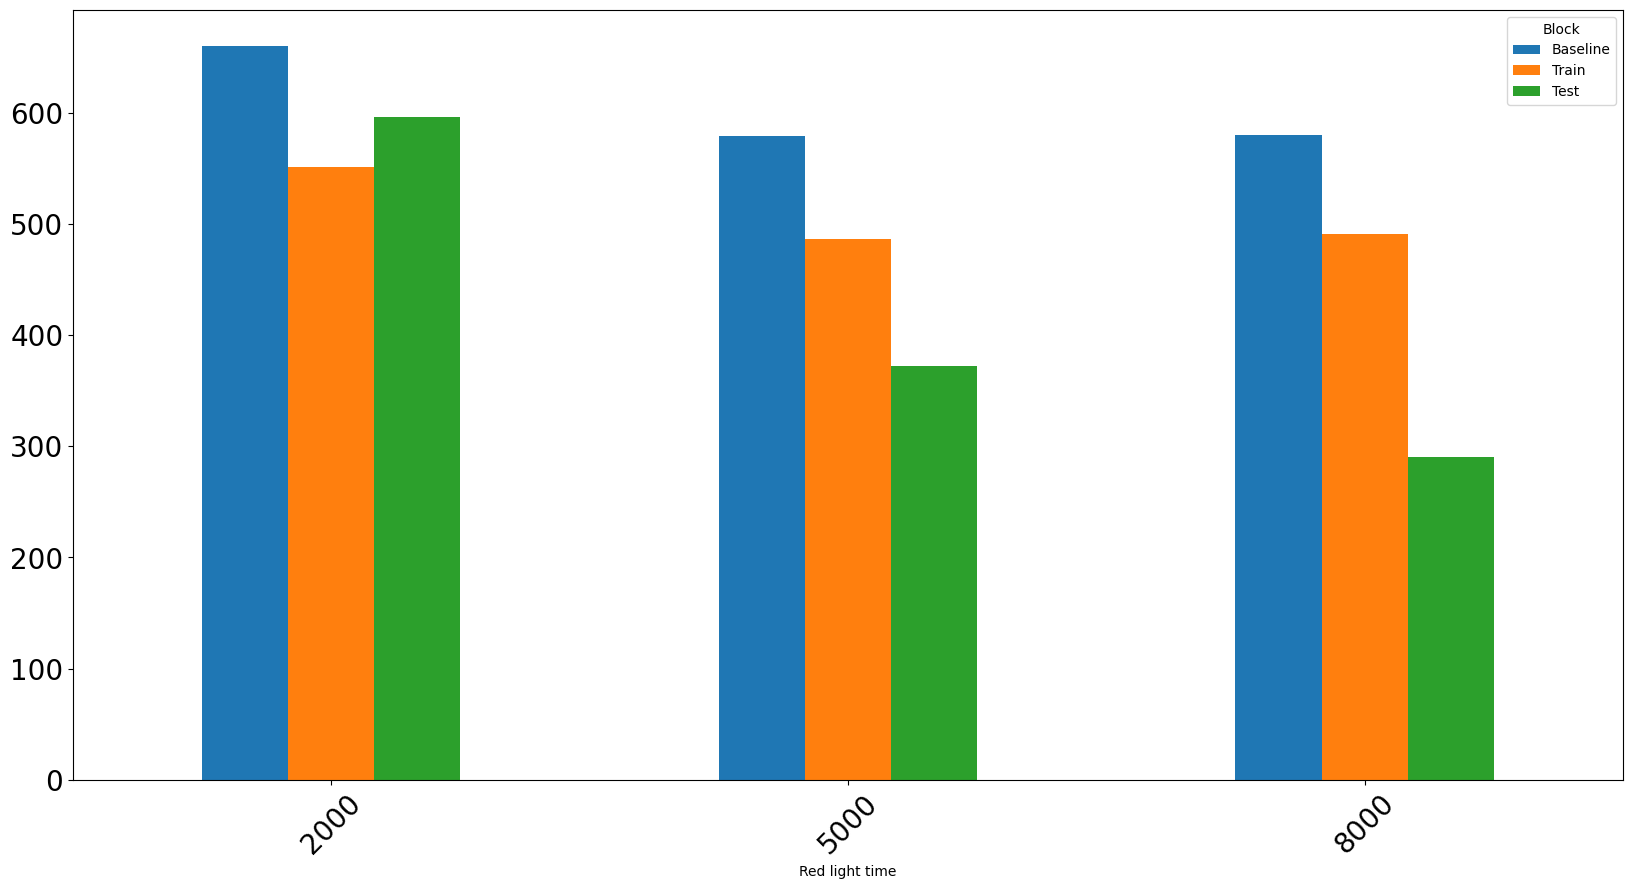

In [162]:
df_averaged.groupby(['Red light time','Block']).mean()['reactionTime'].round(1).unstack(level=1)[cond_order].plot(kind='bar',figsize=(20,10),rot=45,fontsize=20)

## Calculating Relative Error for Averaged Data

In [163]:
df_averaged['RelativeAbsError'] = abs(df_averaged['Brake Time']-df_averaged['Red light time'])/df_averaged['Red light time']

<Axes: >

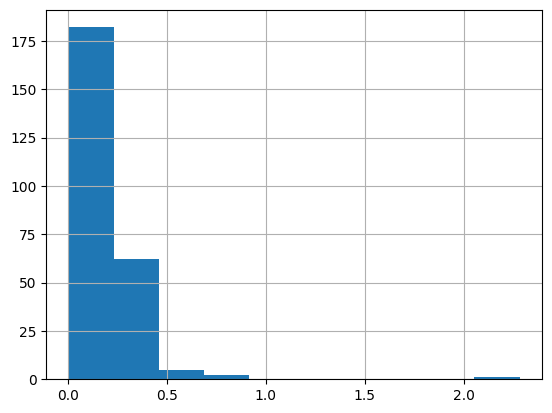

In [164]:
df_averaged['RelativeAbsError'].hist()

In [165]:
df_averaged.groupby(['Red light time','Block']).mean()

<ipython-input-165-782b398a4fe1>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_averaged.groupby(['Red light time','Block']).mean()


Brake Time  Yellow light time  reactionTime  \
Red light time Block                                                    
2000           Baseline  2659.589286              500.0    659.589286   
               Test      2596.017857              500.0    596.017857   
               Train     2551.419643              500.0    551.419643   
5000           Baseline  5578.803571             3500.0    578.803571   
               Test      5372.214286             3500.0    372.214286   
               Train     5486.098214             3500.0    486.098214   
8000           Baseline  8579.744048             6500.0    579.744048   
               Test      8290.214286             6500.0    290.214286   
               Train     8490.839286             6500.0    490.839286   

                         RelativeAbsError  
Red light time Block                       
2000           Baseline          0.329795  
               Test              0.353616  
               Train             0.275710  
5000           Baseline          0.115761  
               Test              0.103743  
               Train             0.100720  
8000           Baseline          0.072468  
               Test              0.057129  
               Train             0.061355

<ipython-input-166-50eba48f7609>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_averaged.groupby(['Red light time','Block']).mean()['RelativeAbsError'].round(4).unstack(level=1)[cond_order].plot(kind='bar',figsize=(20,10),rot=45,fontsize=20)


<Axes: xlabel='Red light time'>

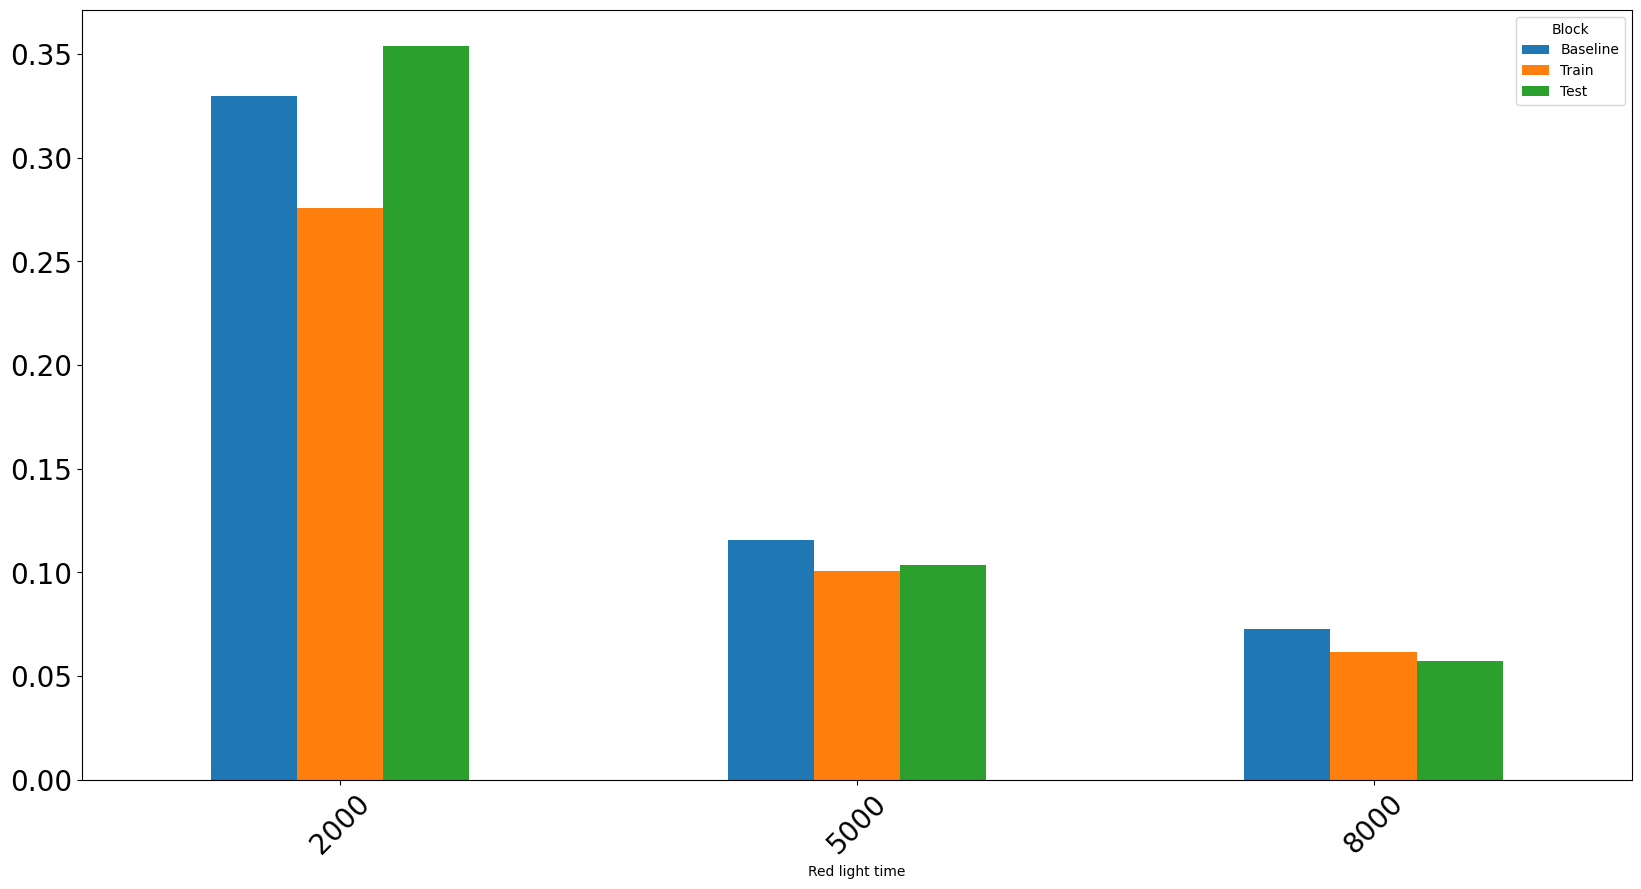

In [166]:
df_averaged.groupby(['Red light time','Block']).mean()['RelativeAbsError'].round(4).unstack(level=1)[cond_order].plot(kind='bar',figsize=(20,10),rot=45,fontsize=20)

Error bars for the Relative Error:

In [167]:
yerr=[df_averaged['RelativeAbsError'].mean() - df_averaged['RelativeAbsError'].min(),
      df_averaged['RelativeAbsError'].max()- df_averaged['RelativeAbsError'].mean()]

In [168]:
yerr

[0.15956623677248674, 2.118883763227513]